In [1]:
from models.model_20250121 import get_model, classifier_image_word, interpretation_class
from pytesseract import pytesseract
import numpy as np
import cv2
import base64
import matplotlib.pyplot as plt

In [21]:

class ImageReader:
    def read(self, path_image: str) -> np.ndarray:
        with open(path_image, "rb") as f:
            chunk = f.read()
        chunk_arr = np.frombuffer(chunk, dtype=np.uint8)
        image = cv2.imdecode(chunk_arr, cv2.IMREAD_COLOR)
        return image

    def readb64(self, encoded_data) -> np.ndarray:
        # encoded_data = uri.split(',')[1]
        nparr = np.fromstring(base64.b64decode(encoded_data), np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        return img

def plot_bbox(bbox, color):
    x0 = bbox["x_top_left"]
    y0 = bbox["y_top_left"]
    w = bbox["width"]
    h = bbox["height"]
    plt.plot([x0, x0+w, x0+w, x0,x0], [y0, y0, y0+h, y0+h, y0], color=color, linewidth=0.5)

/home/daniil/project/font_emb/models/model_20250121.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


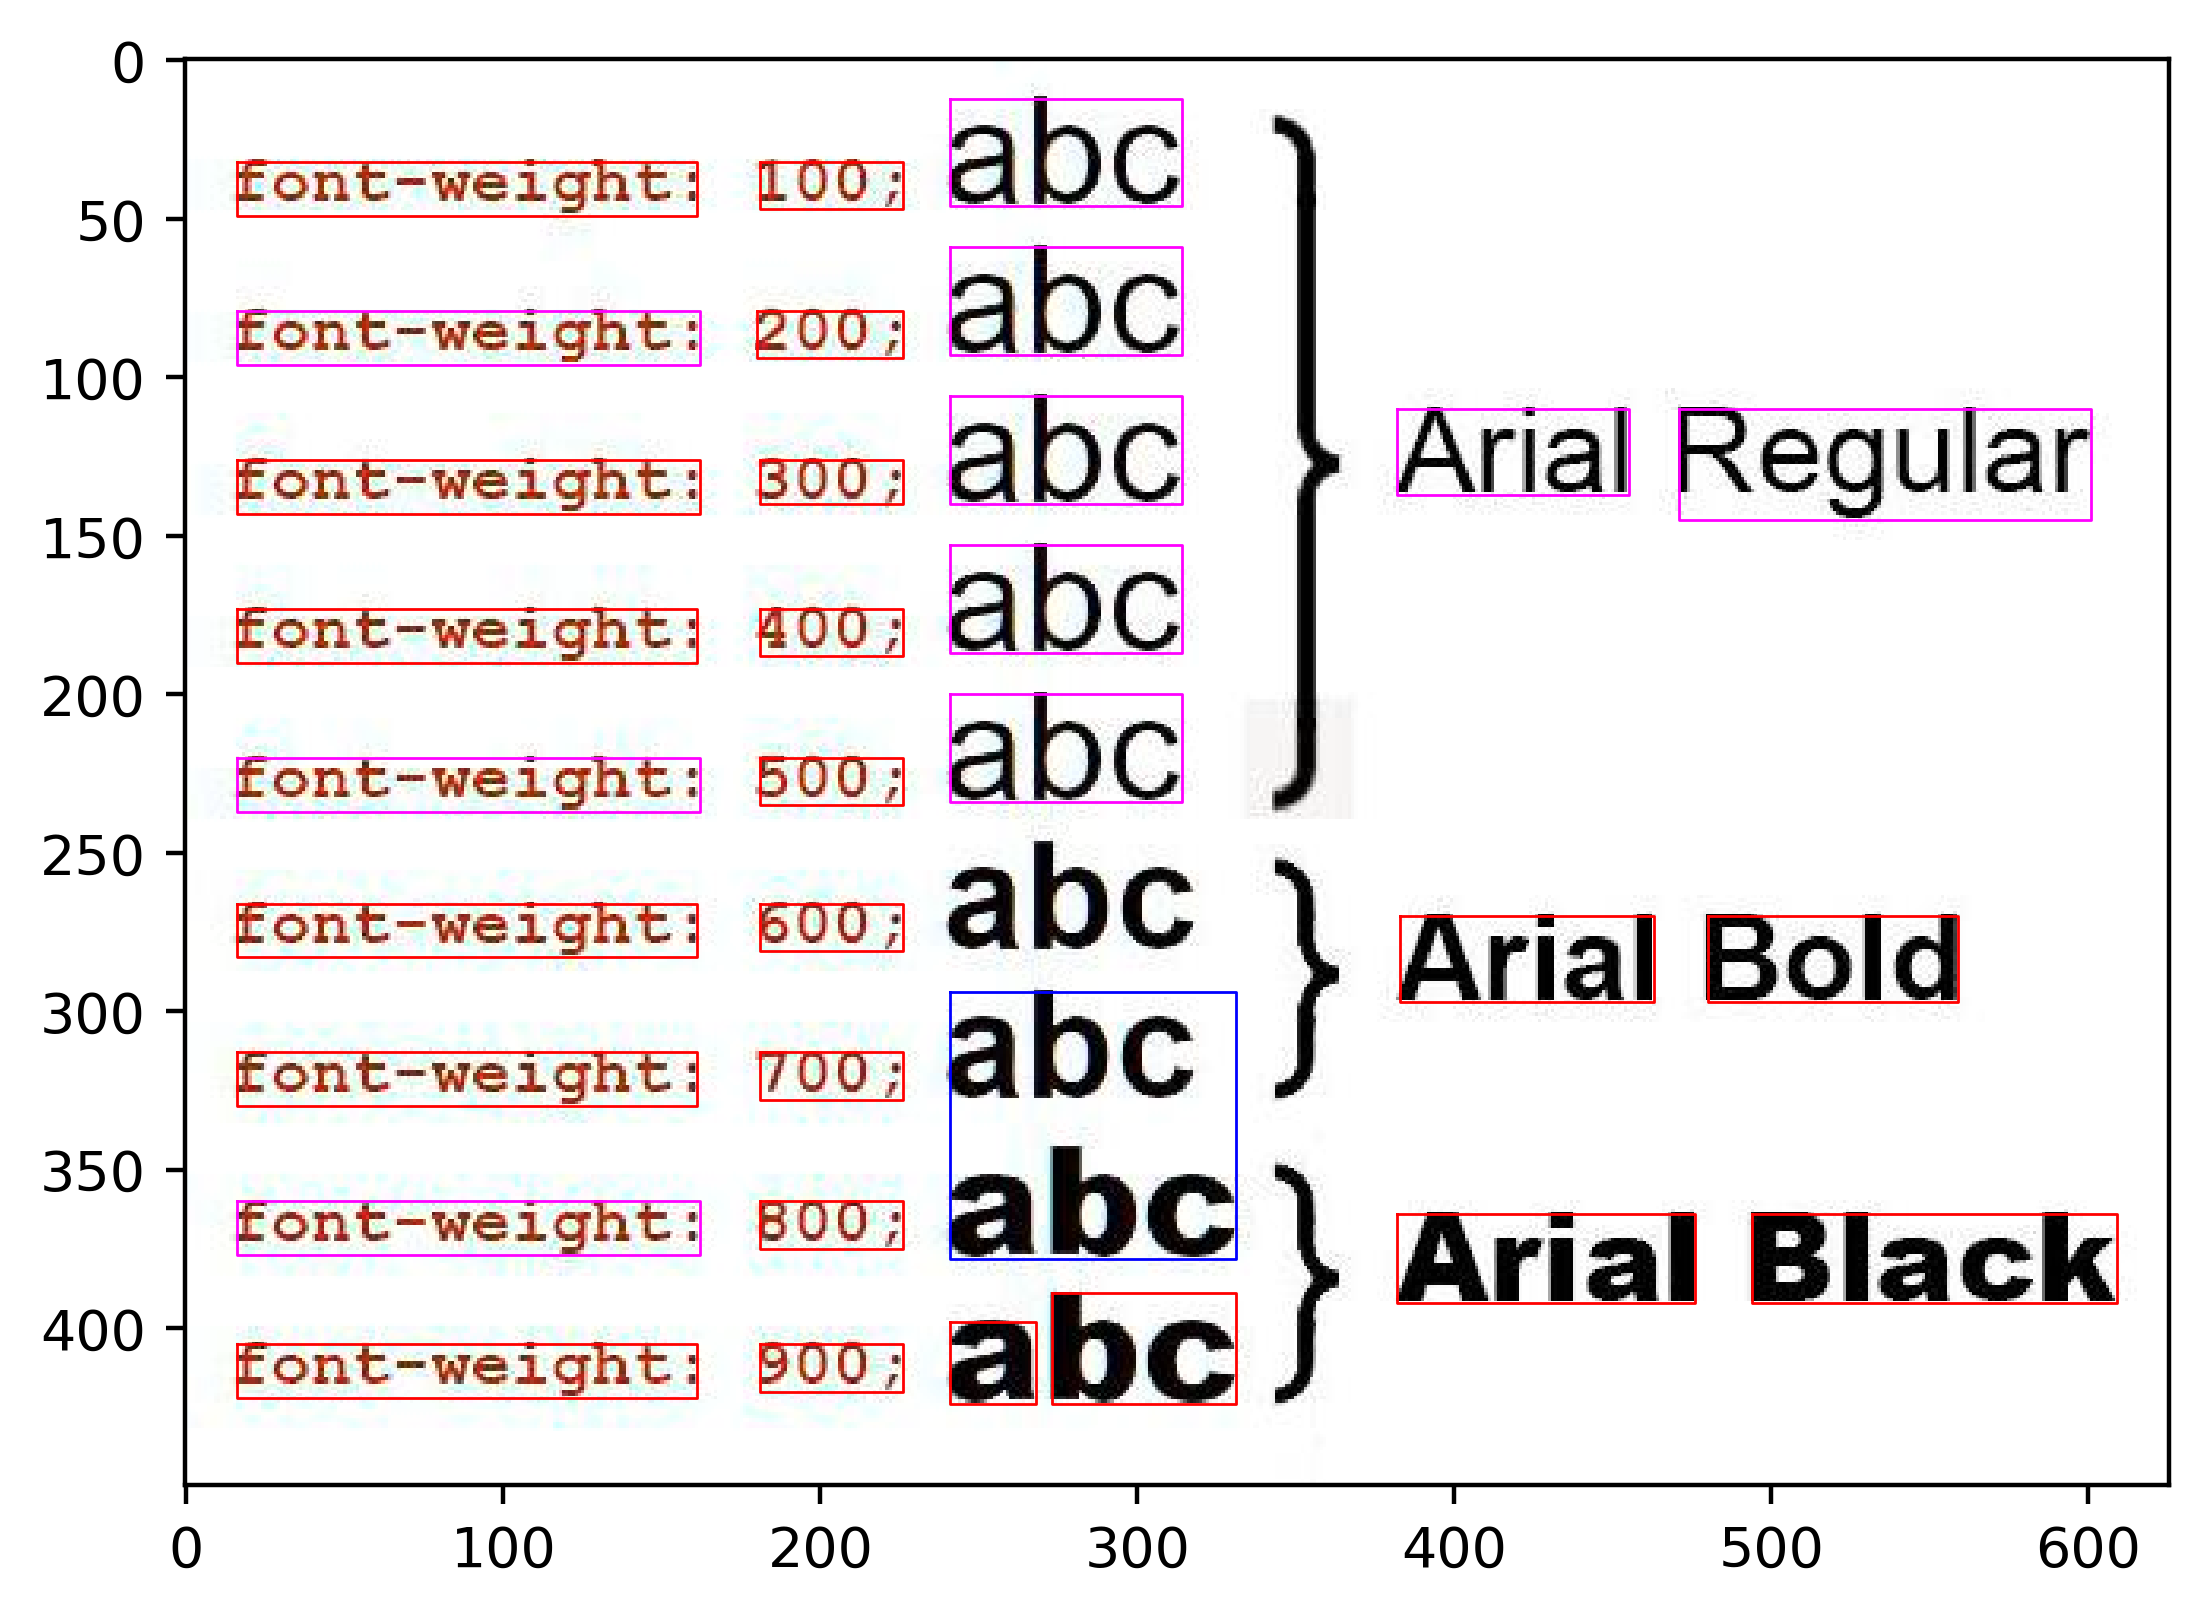

In [26]:
plt.figure(dpi=400)
reader = ImageReader()
img = reader.read("example_img/bold.jpg")
model = get_model("models/model_20250121")

tesseract_bboxes = pytesseract.image_to_data(
        config="-l rus",
        image=img,
        output_type=pytesseract.Output.DICT)
list_bbox = []
list_text = []
for index_bbox, level in enumerate(tesseract_bboxes["level"]):
    if level == 5:
        x_top_left = tesseract_bboxes["left"][index_bbox]
        y_top_left = tesseract_bboxes["top"][index_bbox]
        width = tesseract_bboxes["width"][index_bbox]
        height = tesseract_bboxes["height"][index_bbox]
        if width > 5 and height > 5:
            list_bbox.append({"x_top_left": x_top_left, 
                              "y_top_left": y_top_left, 
                              "width": width, 
                              "height": height})
            list_text.append(tesseract_bboxes["text"][index_bbox])

plt.imshow(img)
COLORS = ["#0000ff", "#ff00ff", "#ff0000" ]
for bbox in list_bbox:
    x0 = bbox["x_top_left"]
    y0 = bbox["y_top_left"]
    w = bbox["width"]
    h = bbox["height"]
    word = img[y0:y0+h, x0:x0+w, :]
    if h<w:
        rez = classifier_image_word(model, word)
        if rez[2] < 0.5:
            r = 0
        elif rez[2] < 1.5:
            r = 1
        else: 
            r = 2
        plot_bbox(bbox, COLORS[r])
